In [1]:

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import os
import keras
import plotly.express as px
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model


In [2]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Load data
train = pd.read_csv('train.csv')
train.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [33]:
train.shape

(7613, 5)

In [34]:
train['text'].isna().sum()

0

In [35]:
test = pd.read_csv('test.csv')
test.head()


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [36]:
test.shape

(3263, 4)

In [37]:
test['text'].isna().sum()

0

<Axes: >

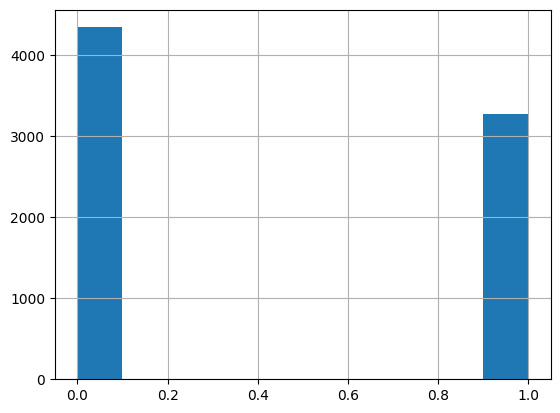

In [5]:
train['target'].hist()

In [6]:

#plot target distribution

target_counts = train['target'].value_counts().reset_index()


target_counts.columns = ['Target', 'Count']

fig = px.bar(target_counts, x='Target', y='Count', title='Frequency Distribution of Target',
             labels={'Count':'Number of Occurrences', 'Target':'Target'}, color='Target')

fig.show()


In [7]:



target_counts = train['target'].value_counts().reset_index()


target_counts.columns = ['Target', 'Count']

fig = px.pie(target_counts, values='Count', names='Target', title='Frequency Distribution of Target')

fig.show()


In [8]:
train['lenght_tweet'] = train['text'].apply(len)

In [9]:
train.head()

,id,keyword,location,text,target,lenght_tweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [11]:
#plot tweets length



fig = px.histogram(train, x='lenght_tweet', nbins=50, title=' length tweet distribution')

fig.show()


In [12]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [13]:



train['text'] = train['text'].astype(str)

# First, we split the tweets into individual words
words = ' '.join(train['text']).split()

# Count the frequency of each word
word_counts = Counter(words)

# Convert the dictionary to a DataFrame
word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index').reset_index()
word_counts_df.columns = ['Word', 'Count']

# Plot the word frequencies using a histogram
fig = px.histogram(word_counts_df, x='Word', y='Count', nbins=50, title='Word Frequency Distribution')

fig.show()


In [14]:



test['text'] = test['text'].astype(str)

# First, we split the tweets into individual words
words = ' '.join(test['text']).split()

# Count the frequency of each word
word_counts = Counter(words)

# Convert the dictionary to a DataFrame
word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index').reset_index()
word_counts_df.columns = ['Word', 'Count']

# Plot the word frequencies using a histogram
fig = px.histogram(word_counts_df, x='Word', y='Count', nbins=50, title='Word Frequency Distribution')

fig.show()


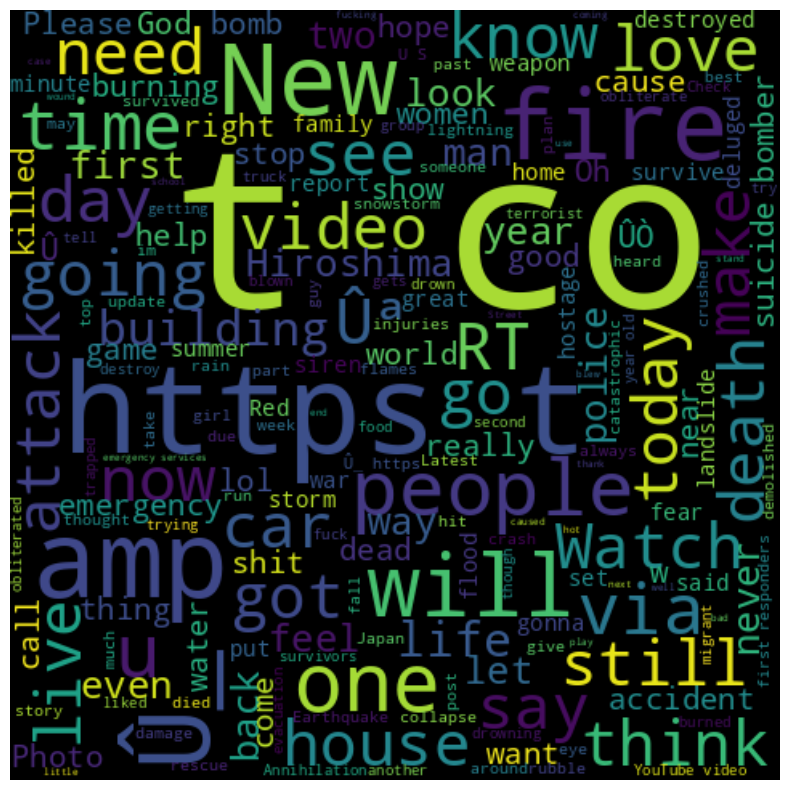

In [15]:

test['text'] = test['text'].astype(str)

# Create a single string with all tweets
text = ' '.join(test['text'])

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)

# Display the generated image
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


In [26]:
#LSTM
# Text preprocessing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove URLs
    text = re.sub(r"http\S|www\S|https\S", '', text, flags=re.MULTILINE)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Lemmatization and remove stopwords
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words)
    return text

train['text'] = train['text'].apply(preprocess_text)
test['text'] = test['text'].apply(preprocess_text)

X_train = train['text']
y_train = train['target']
X_test = test['text']

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
max_length = max([len(s.split()) for s in X_train])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Split train data into train and validation set
X_train_pad, X_val_pad, y_train, y_val = train_test_split(X_train_pad, y_train, test_size=0.2, random_state=42)

if os.path.isfile('my_model.h5'):
    # Load the pre-trained model
    tweet_model_lstm = keras.models.load_model('my_model.h5')
    print('model loaded')
else:
    print('No model found, the model will train')

    # Define LSTM model
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=50, input_length=max_length))
    model.add(LSTM(64, dropout=0.1))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping
    #early_stop = EarlyStopping(monitor='val_loss', patience=20)

    # Fit the model
    model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=100)
    model.save('my_model.h5')
# Validate the model
#_val_pred = model.predict_classes(X_val_pad)
y_val_pred = (model.predict(X_val_pad) > 0.5).astype("int32")
y_test_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

print(classification_report(y_val, y_val_pred))



# Function to predict target class for a given sentence
def predict_target(sentence):
    # Preprocess the sentence
    sentence = preprocess_text(sentence)
    # Convert the sentence to sequence
    sentence_seq = tokenizer.texts_to_sequences([sentence])
    # Padding
    sentence_pad = pad_sequences(sentence_seq, maxlen=max_length, padding='post')
    # Predict and return the target class
    return model.predict(sentence_pad)[0][0]

#use the model for prediction
sentence = input("Please enter your sentence: ")
result = predict_target(sentence)
print("Disaster tweet" if result == 1 else "No disaster")


Epoch 1/100
191/191 [==============================] - 8s 29ms/step - loss: 0.5543 - accuracy: 0.7087 - val_loss: 0.4408 - val_accuracy: 0.8063
Epoch 2/100
191/191 [==============================] - 5s 26ms/step - loss: 0.2800 - accuracy: 0.8929 - val_loss: 0.4515 - val_accuracy: 0.7984
Epoch 3/100
191/191 [==============================] - 5s 26ms/step - loss: 0.1343 - accuracy: 0.9586 - val_loss: 0.5122 - val_accuracy: 0.7787
Epoch 4/100
191/191 [==============================] - 6s 31ms/step - loss: 0.0777 - accuracy: 0.9790 - val_loss: 0.6873 - val_accuracy: 0.7715
Epoch 5/100
191/191 [==============================] - 5s 28ms/step - loss: 0.0551 - accuracy: 0.9836 - val_loss: 0.8398 - val_accuracy: 0.7531
Epoch 6/100
191/191 [==============================] - 5s 25ms/step - loss: 0.0385 - accuracy: 0.9908 - val_loss: 0.8869 - val_accuracy: 0.7472
Epoch 7/100
191/191 [==============================] - 5s 27ms/step - loss: 0.0244 - accuracy: 0.9934 - val_loss: 1.0927 - val_accuracy:

In [39]:

model.save('my_model.h5')


In [42]:
def predict_target(sentence):
    # Load the saved model
    tweet_model_lstm = load_model('my_model')

    # Preprocess the sentence
    sentence = preprocess_text(sentence)
    # Convert the sentence to sequence
    sentence_seq = tokenizer.texts_to_sequences([sentence])
    # Padding
    sentence_pad = pad_sequences(sentence_seq, maxlen=max_length, padding='post')
    # Predict and return the target class
    return tweet_model_lstm.predict(sentence_pad)[0][0]
# prediction
sentence = input("Please enter your sentence: ")
result = predict_target(sentence)
print("Disaster tweet" if result == 1 else "No disaster")


Please enter your sentence: i can see fire
1/1 [==============================] - 0s 354ms/step
No disaster


In [30]:
#logistic regression


# Text preprocessing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r"http\S|www\S|https\S", '', text, flags=re.MULTILINE)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words)
    return text

train['text'] = train['text'].apply(preprocess_text)
test['text'] = test['text'].apply(preprocess_text)

X_train = train['text']
y_train = train['target']
X_test = test['text']

# CountVectorizer to convert the text data into a matrix of token counts
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Split train data into train and validation set
X_train_vectorized, X_val_vectorized, y_train, y_val = train_test_split(X_train_vectorized, y_train, test_size=0.2, random_state=42)

# Define Logistic Regression model
model = LogisticRegression()

# Fit the model
model.fit(X_train_vectorized, y_train)

# Validate the model
y_val_pred = model.predict(X_val_vectorized)
y_test_pred = model.predict(X_test_vectorized)

print(classification_report(y_val, y_val_pred))

# Function to predict target class for a given sentence
def predict_target(sentence):
    # Preprocess the sentence
    sentence = preprocess_text(sentence)
    # Convert the sentence to vector
    sentence_vectorized = vectorizer.transform([sentence])
    # Predict and return the target class
    return model.predict(sentence_vectorized)[0]

# PREDICTION
sentence = input("Please enter your sentence: ")
result = predict_target(sentence)
print("Disaster tweet" if result == 1 else "No disaster")


              precision    recall  f1-score   support

           0       0.80      0.86      0.83       874
           1       0.79      0.70      0.74       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.79      1523
weighted avg       0.79      0.79      0.79      1523

Please enter your sentence: i can see fire
Disaster tweet


In [23]:

#Random forest

# Text preprocessing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r"http\S|www\S|https\S", '', text, flags=re.MULTILINE)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words)
    return text

train['text'] = train['text'].apply(preprocess_text)
test['text'] = test['text'].apply(preprocess_text)

X_train = train['text']
y_train = train['target']
X_test = test['text']

# CountVectorizer to convert the text data into a matrix of token counts
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Split train data into train and validation set
X_train_vectorized, X_val_vectorized, y_train, y_val = train_test_split(X_train_vectorized, y_train, test_size=0.2, random_state=42)

# Define Random Forest model
model = RandomForestClassifier()

# Fit the model
model.fit(X_train_vectorized, y_train)

# Validate the model
y_val_pred = model.predict(X_val_vectorized)
y_test_pred = model.predict(X_test_vectorized)

print(classification_report(y_val, y_val_pred))

# Function to predict target class for a given sentence
def predict_target(sentence):
    # Preprocess the sentence
    sentence = preprocess_text(sentence)
    # Convert the sentence to vector
    sentence_vectorized = vectorizer.transform([sentence])
    # Predict and return the target class
    return model.predict(sentence_vectorized)[0]

# prediction
sentence = input("Please enter your sentence: ")
result = predict_target(sentence)
print("Disaster tweet" if result == 1 else "No disaster")


              precision    recall  f1-score   support

           0       0.77      0.89      0.82       874
           1       0.81      0.64      0.71       649

    accuracy                           0.78      1523
   macro avg       0.79      0.76      0.77      1523
weighted avg       0.79      0.78      0.78      1523

Please enter your sentence: i can see fire
Disaster tweet


In [24]:





# Text preprocessing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r"http\S|www\S|https\S", '', text, flags=re.MULTILINE)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words)
    return text

train['text'] = train['text'].apply(preprocess_text)
test['text'] = test['text'].apply(preprocess_text)

X_train = train['text']
y_train = train['target']
X_test = test['text']

# CountVectorizer to convert the text data into a matrix of token counts
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Split train data into train and validation set
X_train_vectorized, X_val_vectorized, y_train, y_val = train_test_split(X_train_vectorized, y_train, test_size=0.2, random_state=42)

# Define SVM model
model = SVC(probability=True)  # 'probability = True' is needed for predict_proba

# Fit the model
model.fit(X_train_vectorized, y_train)

# Validate the model
y_val_pred = model.predict(X_val_vectorized)
y_test_pred = model.predict(X_test_vectorized)

print(classification_report(y_val, y_val_pred))

# Function to predict target class for a given sentence
def predict_target(sentence):
    # Preprocess the sentence
    sentence = preprocess_text(sentence)
    # Convert the sentence to vector
    sentence_vectorized = vectorizer.transform([sentence])
    # Predict and return the target class
    return model.predict(sentence_vectorized)[0]

# Example usage
sentence = input("Please enter your sentence: ")
result = predict_target(sentence)
print("Disaster tweet" if result == 1 else "No disaster")


              precision    recall  f1-score   support

           0       0.79      0.91      0.84       874
           1       0.84      0.67      0.74       649

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523

Please enter your sentence: i can see fire
Disaster tweet


In [25]:
# DecisionTreeClassifier
# Text preprocessing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r"http\S|www\S|https\S", '', text, flags=re.MULTILINE)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words)
    return text

train['text'] = train['text'].apply(preprocess_text)
test['text'] = test['text'].apply(preprocess_text)

X_train = train['text']
y_train = train['target']
X_test = test['text']

# CountVectorizer to convert the text data into a matrix of token counts
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Split train data into train and validation set
X_train_vectorized, X_val_vectorized, y_train, y_val = train_test_split(X_train_vectorized, y_train, test_size=0.2, random_state=42)

# Define Decision Tree model
model = DecisionTreeClassifier()

# Fit the model
model.fit(X_train_vectorized, y_train)

# Validate the model
y_val_pred = model.predict(X_val_vectorized)
y_test_pred = model.predict(X_test_vectorized)

print(classification_report(y_val, y_val_pred))

# Function to predict target class for a given sentence
def predict_target(sentence):
    # Preprocess the sentence
    sentence = preprocess_text(sentence)
    # Convert the sentence to vector
    sentence_vectorized = vectorizer.transform([sentence])
    # Predict and return the target class
    return model.predict(sentence_vectorized)[0]

# Example usage
sentence = input("Please enter your sentence: ")
result = predict_target(sentence)
print("Disaster tweet" if result == 1 else "No disaster")


              precision    recall  f1-score   support

           0       0.78      0.79      0.79       874
           1       0.71      0.69      0.70       649

    accuracy                           0.75      1523
   macro avg       0.75      0.74      0.74      1523
weighted avg       0.75      0.75      0.75      1523

Please enter your sentence: i can see fire
Disaster tweet


In [43]:

#RNN
# Define RNN model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=50, input_length=max_length))
model.add(SimpleRNN(64, dropout=0.1))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=100)

# Validate the model
y_val_pred = (model.predict(X_val_pad) > 0.5).astype("int32")
y_test_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

print(classification_report(y_val, y_val_pred))

# Function to predict target class for a given sentence
def predict_target(sentence):
    # Preprocess the sentence
    sentence = preprocess_text(sentence)
    # Convert the sentence to sequence
    sentence_seq = tokenizer.texts_to_sequences([sentence])
    # Padding
    sentence_pad = pad_sequences(sentence_seq, maxlen=max_length, padding='post')
    # Predict and return the target class
    return (model.predict(sentence_pad) > 0.5).astype("int32")

# Example usage
sentence = input("Please enter your sentence: ")
result = predict_target(sentence)
print("Disaster tweet" if result[0][0] == 1 else "No disaster")


Epoch 1/100
191/191 [==============================] - 5s 18ms/step - loss: 0.5563 - accuracy: 0.7166 - val_loss: 0.4861 - val_accuracy: 0.7912
Epoch 2/100
191/191 [==============================] - 3s 16ms/step - loss: 0.2654 - accuracy: 0.9003 - val_loss: 0.6435 - val_accuracy: 0.7137
Epoch 3/100
191/191 [==============================] - 4s 20ms/step - loss: 0.0967 - accuracy: 0.9680 - val_loss: 0.8764 - val_accuracy: 0.7380
Epoch 4/100
191/191 [==============================] - 3s 16ms/step - loss: 0.0566 - accuracy: 0.9808 - val_loss: 0.7384 - val_accuracy: 0.7479
Epoch 5/100
191/191 [==============================] - 3s 16ms/step - loss: 0.0382 - accuracy: 0.9865 - val_loss: 0.7633 - val_accuracy: 0.7360
Epoch 6/100
191/191 [==============================] - 3s 18ms/step - loss: 0.0282 - accuracy: 0.9890 - val_loss: 0.8433 - val_accuracy: 0.7367
Epoch 7/100
191/191 [==============================] - 4s 20ms/step - loss: 0.0241 - accuracy: 0.9913 - val_loss: 1.0262 - val_accuracy:

In [44]:
model.save('RNN_model.h5')


In [48]:
def predict_target(sentence):
    # Load the saved model
    tweet_model_RNN = load_model('my_model')

    # Preprocess the sentence
    sentence = preprocess_text(sentence)
    # Convert the sentence to sequence
    sentence_seq = tokenizer.texts_to_sequences([sentence])
    # Padding
    sentence_pad = pad_sequences(sentence_seq, maxlen=max_length, padding='post')
    # Predict and return the target class
    return tweet_model_RNN.predict(sentence_pad)[0][0]
# prediction
sentence = input("Please enter your sentence: ")
result = predict_target(sentence)
print("Disaster tweet" if result == 1 else "No disaster")

Please enter your sentence: its a fire
1/1 [==============================] - 0s 341ms/step
No disaster
